In [1]:
#1. Import Libraries

In [2]:
#step 1 - import all libraries for data handling, feature extraction, clustering and plotting
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [3]:
#2. Data Loading Functions

In [4]:
#step 2 - define function to load tweets data from the Dataset folder
def load_tweets_data():
    #use relative path
    tweets_data = pd.read_csv("../Dataset/tweets.csv")
    return tweets_data

In [5]:
#step 3 - define function to load NRC emotion lexicon from the Lexicon folder
def load_nrc_lexicon():
    #use relative path
    lexicon_path = "../Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
    lexicon = {}
    with open(lexicon_path, "r", encoding="utf-8") as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 3:
                word, emotion, value = parts
                if word not in lexicon:
                    lexicon[word] = {}
                lexicon[word][emotion] = int(value)
    return lexicon

In [6]:
#testing of 2. Data Loading Functions
tweets = load_tweets_data()
lexicon = load_nrc_lexicon()
print(tweets.head())
print(list(lexicon.items())[:5])

   id                                               link  \
0   0  https://twitter.com/HackneyPSC/status/17274436...   
1   1  https://twitter.com/cherrysattitude/status/172...   
2   2  https://twitter.com/diamoundgirls2/status/1710...   
3   3  https://twitter.com/mmtchi/status/172764634165...   
4   4  https://twitter.com/NoahIeeNG/status/172744319...   

                                                text              date  likes  \
0  A statement from psychoanalytic activists:  Th...  11/22/2023 21:47      0   
1                        bak bak bak bak doyamadınız  11/22/2023 15:27    443   
2  Check out 🏒 35 + different ERIK KARLSSON cards...    10/7/2023 7:15      0   
3  Il s'en passe des trucs pendant qu'on vous ori...  11/23/2023 11:12    381   
4  AW OKAY.. WELL THATS COOL, IM SURE PAL WILL AP...  11/22/2023 21:45      0   

   comments  
0         0  
1         9  
2         0  
3        44  
4         0  
[('aback', {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 

In [7]:
#3. Data Preprocessing

In [8]:
#step 1 - define function to preprocess the tweets data
def preprocess_tweets_data(tweets_data):
    #remove rows with missing tweets
    tweets_data = tweets_data.dropna(subset=["text"]).copy()
    #convert text to lowercase for consistency
    tweets_data["text"] = tweets_data["text"].str.lower()
    #remove links
    tweets_data["text"] = tweets_data["text"].apply(lambda x: re.sub(r"http\S+|www\S+|https\S+", "", x))
    return tweets_data

In [9]:
#testing
tweets = load_tweets_data()
tweets = preprocess_tweets_data(tweets)
print(tweets.head())

   id                                               link  \
0   0  https://twitter.com/HackneyPSC/status/17274436...   
1   1  https://twitter.com/cherrysattitude/status/172...   
2   2  https://twitter.com/diamoundgirls2/status/1710...   
3   3  https://twitter.com/mmtchi/status/172764634165...   
4   4  https://twitter.com/NoahIeeNG/status/172744319...   

                                                text              date  likes  \
0  a statement from psychoanalytic activists:  th...  11/22/2023 21:47      0   
1                        bak bak bak bak doyamadınız  11/22/2023 15:27    443   
2  check out 🏒 35 + different erik karlsson cards...    10/7/2023 7:15      0   
3  il s'en passe des trucs pendant qu'on vous ori...  11/23/2023 11:12    381   
4  aw okay.. well thats cool, im sure pal will ap...  11/22/2023 21:45      0   

   comments  
0         0  
1         9  
2         0  
3        44  
4         0  


In [10]:
#4. Feature Extraction

In [11]:
def add_week_column(tweets_data):
    #parse data as datetime
    tweets_data["date"] = pd.to_datetime(tweets_data["date"], errors="coerce")
    tweets_data["year_week"] = tweets_data["date"].dt.strftime('%Y-%U')
    return tweets_data

In [12]:
#step 1 - extract username from twitter link
def extract_username(link):
    match = re.search(r"twitter\.com/([^/]+)/status", str(link))
    if match: 
        return match.group(1)
    else:
        return "unknown"

#step 2 - a function to count emoji in text
def count_emojis(text):
    emoji_pattern = re.compile(
    r"[\U0001F600-\U0001F64F"
    r"\U0001F300-\U0001F5FF"
    r"\U0001F680-\U0001F6FF"
    r"\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
    return len(emoji_pattern.findall(str(text)))

#step 3 - function to count hashtags
def count_hashtags(text):
    return len(re.findall(r"#\w+", str(text)))

#step 4 - function to get tweet length (num of characters)
def get_tweet_length(text):
    return len(str(text))

#step 5 - function to count emotional words using NRC lexicon
def count_emotion_words(text, lexicon, emotion):
    words = str(text).split()
    count = 0 
    for word in words:
        if word in lexicon and lexicon[word].get(emotion, 0) == 1:
            count += 1
    return count

#step 6 - main function to extract all features for each tweet
def extract_features(tweets_data, lexicon):
    #extract username from link
    tweets_data["username"] = tweets_data["link"].apply(extract_username)
    #create feature columns for emoji, hashtags, tweet length, likes and comments
    tweets_data["emoji_count"] = tweets_data["text"].apply(count_emojis)
    tweets_data["hashtag_count"] = tweets_data["text"].apply(count_hashtags) 
    tweets_data["tweet_length"] = tweets_data["text"].apply(get_tweet_length)
    #convert like and comment columns to numeric
    tweets_data["likes"] = pd.to_numeric(tweets_data["likes"], errors="coerce").fillna(0)
    tweets_data["comments"] = pd.to_numeric(tweets_data["comments"], errors="coerce")
    #add NRC emotion features one column per emotion
    emotions = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust", "positive", "negative"]
    for emotion in emotions:
        tweets_data[f"emotion_{emotion}_count"] = tweets_data["text"].apply(lambda x: count_emotion_words(x, lexicon, emotion))
    return tweets_data

In [13]:
#testing
tweets = extract_features(tweets, lexicon)
print(tweets[["username", "text", "emoji_count", "hashtag_count", "likes", "comments"]].head())

          username                                               text  \
0       HackneyPSC  a statement from psychoanalytic activists:  th...   
1  cherrysattitude                        bak bak bak bak doyamadınız   
2   diamoundgirls2  check out 🏒 35 + different erik karlsson cards...   
3           mmtchi  il s'en passe des trucs pendant qu'on vous ori...   
4        NoahIeeNG  aw okay.. well thats cool, im sure pal will ap...   

   emoji_count  hashtag_count  likes  comments  
0            0              0      0         0  
1            0              0    443         9  
2            1              4      0         0  
3            0              1    381        44  
4            0              0      0         0  


In [14]:
tweets = add_week_column(tweets)

In [15]:
def cap_tweet_length(tweets_data, max_length=1000):
    tweets_data["tweet_length_capped"] = tweets_data["tweet_length"].clip(upper=max_length)
    return tweets_data

In [16]:
tweets = cap_tweet_length(tweets, max_length=1000)

In [17]:
#5.

In [18]:
#step 1 - define function to aggregate tweet-level features to user-level
def aggregate_weekly_features(tweets_data):
    #group by username and year_week
    weekly = tweets_data.groupby(["username", "year_week"]).agg({
        "emoji_count": "mean",
        "hashtag_count": "mean",
        "tweet_length_capped": "mean",
        "emotion_anger_count": "mean",
        "emotion_sadness_count": "mean",
        "emotion_joy_count": "mean",
        "text": "count"
    }).rename(columns={"text": "tweet_count"}).reset_index()
    return weekly

In [19]:
#test
weekly_features = aggregate_weekly_features(tweets)
print(weekly_features.head())

      username year_week  emoji_count  hashtag_count  tweet_length_capped  \
0    001Flight   2023-50          0.0            0.0                 63.0   
1    0130Coach   2023-50          0.0            0.0                453.0   
2       01IOTA   2023-50          0.0            0.0                280.0   
3  021Scenario   2023-50          0.0            0.0                 40.0   
4        06Kiu   2023-47          0.0            0.0                 73.0   

   emotion_anger_count  emotion_sadness_count  emotion_joy_count  tweet_count  
0                  0.0                    0.0                0.0            1  
1                  1.0                    2.0                0.0            1  
2                  2.0                    1.0                0.0            1  
3                  0.0                    0.0                0.0            1  
4                  0.0                    0.0                0.0            1  


In [20]:
#behaviour change score
def calculate_behaviour_change(weekly_features):
    #each user needs standard deviation of weekly features
    feature_columns = [col for col in weekly_features.columns if col not in ["username", "year_week"]]
    behaviour_change = weekly_features.groupby("username")[feature_columns].std().add_suffix("_change_score").reset_index()
    return behaviour_change

In [21]:
behaviour_change = calculate_behaviour_change(weekly_features)

In [22]:
def summarise_user_features(weekly_features, behaviour_change):
    feature_columns = [col for col in weekly_features.columns if col not in ["username", "year_week"]]
    user_means = weekly_features.groupby("username")[feature_columns].mean().reset_index()
    #merge with behaviour change scores
    user_summary = pd.merge(user_means, behaviour_change, on="username", how="left")
    user_summary = user_summary.fillna(0)
    return user_summary

In [23]:
user_summary = summarise_user_features(weekly_features, behaviour_change)
user_summary["tweet_length_capped"] = user_summary["tweet_length_capped"].clip(upper=1000)

In [24]:
#6. Feature Scaling

In [25]:
#step 1 - define function to scale user features using Standard Scaler
def scale_features(user_features):
    #select only numeric columns for scaling - skip "username" and strings columns
    feature_columns = [col for col in user_features.columns if col not in ["username", "likes", "comments", "year_week"] and user_features[col].dtype in ['int64', 'float64']]
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(user_features[feature_columns])
    #create a new DataFrame with the scaled values + skipped "username"
    scaled_df = pd.DataFrame(scaled_values, columns=feature_columns)
    scaled_df["username"] = user_features["username"].values
    #add likes and comments for post-cluster analysis
    if "likes" in user_features.columns:
        scaled_df["likes"] = user_features["likes"].values
    if "comments" in user_features.columns:
        scaled_df["comments"] = user_features["comments"].values
    #return the scaled Dataframe
    return scaled_df

In [26]:
#test
scaled_df = scale_features(weekly_features)
print(scaled_df.head())

   emoji_count  hashtag_count  tweet_length_capped  emotion_anger_count  \
0    -0.222905      -0.279901            -0.890869            -0.451340   
1    -0.222905      -0.279901             2.207283             0.401808   
2    -0.222905      -0.279901             0.832975             1.254957   
3    -0.222905      -0.279901            -1.073580            -0.451340   
4    -0.222905      -0.279901            -0.811429            -0.451340   

   emotion_sadness_count  emotion_joy_count  tweet_count     username  
0              -0.445663          -0.319534    -0.247233    001Flight  
1               1.470693          -0.319534    -0.247233    0130Coach  
2               0.512515          -0.319534    -0.247233       01IOTA  
3              -0.445663          -0.319534    -0.247233  021Scenario  
4              -0.445663          -0.319534    -0.247233        06Kiu  


k=2, silhouette score=0.841
k=3, silhouette score=0.415
k=4, silhouette score=0.422
k=5, silhouette score=0.424
k=6, silhouette score=0.217
k=7, silhouette score=0.217
k=8, silhouette score=0.353
k=9, silhouette score=0.230


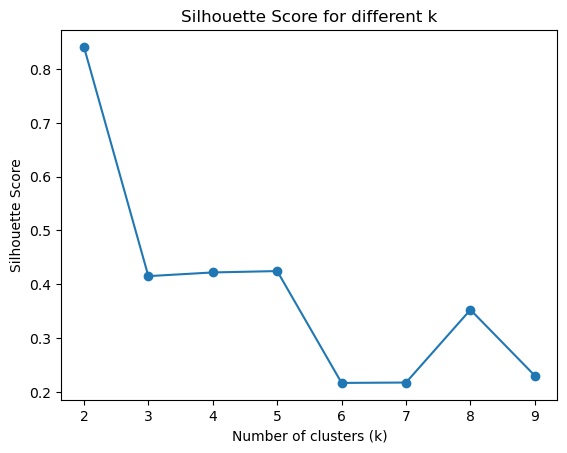

In [27]:
scaled_df = scale_features(user_summary)
feature_columns = [col for col in scaled_df.columns if col not in ["username", "kmeans_cluster", "dbscan_cluster", "likes", "comments"]]
X = scaled_df[feature_columns].values

silhouette_scores = []
k_range = range (2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f"k={k}, silhouette score={score:.3f}")

import matplotlib.pyplot as plt
plt.plot(list(k_range), silhouette_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for different k")
plt.show()

In [28]:
#7. Clustering

In [29]:
#step 1 - function to apply KMeans 
def apply_kmeans(scaled_df, num_clusters=3):
    #selec numeric columns + skip username
    feature_columns = scaled_df.columns.drop("username")
    #create and fit KMneans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_df[feature_columns])
    #add cluster labels to dataframe
    scaled_df["kmeans_cluster"] = cluster_labels
    #return dataframe and model
    return scaled_df, kmeans

#step 2 - function to apply DBSCAN clustering
def apply_dbscan(scaled_df, eps=1.0, min_samples=5):
    #select numeric columns + skip username and kmeans
    feature_columns = scaled_df.columns.drop(["username", "kmeans_cluster"], errors="ignore")
    #create and fit DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(scaled_df[feature_columns])
    #add cluster labels to dataframe
    scaled_df["dbscan_cluster"] = dbscan_labels
    #return
    return scaled_df, dbscan

In [30]:
#testing
#apply kmeans clustering + number of clusters
scaled_df, kmeans = apply_kmeans(scaled_df, num_clusters=5)

#apply dbscan clustering 
scaled_df, dbscan = apply_dbscan(scaled_df, eps=1.5, min_samples=5)

#results
print(scaled_df[["username", "kmeans_cluster", "dbscan_cluster"]].head())

      username  kmeans_cluster  dbscan_cluster
0    001Flight               4               0
1    0130Coach               0               0
2       01IOTA               0               0
3  021Scenario               4               0
4        06Kiu               4               0


In [31]:
#8. Evaluation

In [32]:
#function to evaluate kmeans with silhouette score
def evaluate_kmeans(scaled_df):
    feature_columns = [col for col in scaled_df.columns if col not in ["username", "kmeans_cluster", "dbscan_cluster"]]
    #silhouette score
    labels = scaled_df["kmeans_cluster"]
    score = silhouette_score(scaled_df[feature_columns], labels)
    print("KMeans Silhouette Score:", round(score, 3))
    #cluster sizes
    print("KMeans Cluster Counts:\n", scaled_df["kmeans_cluster"].value_counts())
    #mean values per cluster
    print("KMeans Feature Means per Cluster:\n", scaled_df.groupby("kmeans_cluster")[feature_columns].mean())

#fn to evaluate dbscan 
def evaluate_dbscan(scaled_df):
    #print inclusing outliers (-1)
    print("DBSCAN Cluster Counts including Outliers:\n", scaled_df["dbscan_cluster"].value_counts())
    #mean values per cluster
    feature_columns = [col for col in scaled_df.columns if col not in ["username", "kmeans_cluster", "dbscan_cluster"]]
    print("DBSCAN Feature Means per Cluster:\n", scaled_df.groupby("dbscan_cluster")[feature_columns].mean())

#plot elbow method for KMeans
def plot_elbow_method(scaled_df, max_k=8):
    feature_columns = [col for col in scaled_df.columns if col not in ["username", "kmeans_cluster", "dbscan_cluster"]]
    inertia = []
    k_range = range(2, max_k+1)
    #fit KMeans for each value of k
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(scaled_df[feature_columns])
        inertia.append(kmeans.inertia_)
    #elbow curve plot
    plt.plot(list(k_range), inertia, marker='o')
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia")
    plt.title("Elbow Method for KMeans")
    plt.show()

KMeans Silhouette Score: 0.396
KMeans Cluster Counts:
 kmeans_cluster
4    8770
0    1653
3     209
1      27
2       1
Name: count, dtype: int64
KMeans Feature Means per Cluster:
                 emoji_count  hashtag_count  tweet_length_capped  \
kmeans_cluster                                                    
0                  0.103089       0.010987             1.052992   
1                 -0.058195       0.043406             2.637367   
2                 -0.216593      23.751323             6.819094   
3                  0.330899       0.371831             0.660138   
4                 -0.027113      -0.013774            -0.223101   

                emotion_anger_count  emotion_sadness_count  emotion_joy_count  \
kmeans_cluster                                                                  
0                          1.198130               1.229127           0.676587   
1                          1.877566               1.523021           1.085441   
2                        

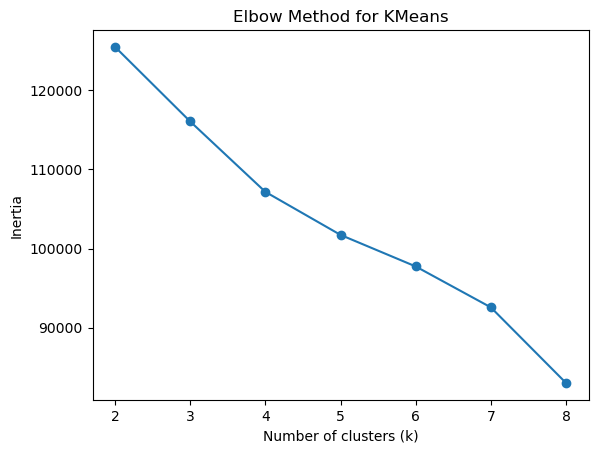

In [33]:
#check
evaluate_kmeans(scaled_df)
evaluate_dbscan(scaled_df)
plot_elbow_method(scaled_df)

In [34]:
#9. Plotting

In [35]:
#function to plot cluster sizes
def plot_cluster_sizes(scaled_df, cluster_column):
    #num of clusters in each column
    counts = scaled_df[cluster_column].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    counts.plot(kind='bar')
    plt.xlabel("Cluster Label")
    plt.ylabel("Number of Users")
    plt.title(f"{cluster_column} Sizes")
    plt.show()

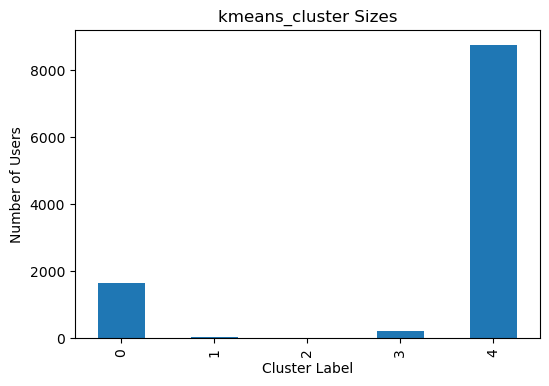

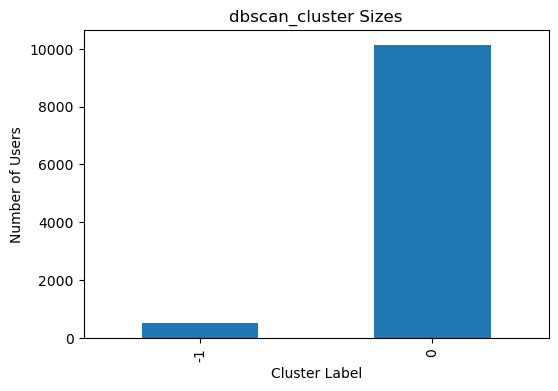

In [36]:
plot_cluster_sizes(scaled_df, "kmeans_cluster")
plot_cluster_sizes(scaled_df, "dbscan_cluster")

In [37]:
print(user_summary[["tweet_count", "emoji_count", "hashtag_count", "tweet_length_capped"]].describe())
print(user_summary[["emotion_joy_count", "emotion_anger_count", "emotion_sadness_count"]].describe())


        tweet_count   emoji_count  hashtag_count  tweet_length_capped
count  10660.000000  10660.000000   10660.000000         10660.000000
mean       1.367398      0.160374       0.447501           172.397208
std        1.517727      0.740471       1.623249           121.371203
min        1.000000      0.000000       0.000000             0.000000
25%        1.000000      0.000000       0.000000            86.000000
50%        1.000000      0.000000       0.000000           159.000000
75%        1.000000      0.000000       0.000000           245.000000
max       84.000000     38.000000      50.000000          1000.000000
       emotion_joy_count  emotion_anger_count  emotion_sadness_count
count       10660.000000         10660.000000           10660.000000
mean            0.253696             0.521421               0.459447
std             0.802179             1.161636               1.038082
min             0.000000             0.000000               0.000000
25%             0.000000 